In [5]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
sys.path.append('../pipeline')
# sys.path.append('../BayDS/lib')
%load_ext autoreload
%autoreload 2

from selection_validation import * 
from dynamics import * 
from preselection import * 
# from EDA import *

from catboost import CatBoostClassifier

from BayDS.lib.training import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_train = pd.read_csv('data/onetwotrip_challenge_train.csv')
df_test = pd.read_csv('data/onetwotrip_challenge_test.csv')

features = list(filter(lambda x: 'field' in x , df_train.columns))

train = df_train.copy()[features + ['orderid', 'userid', 'goal1']]
test = df_test.copy()[features + ['orderid', 'userid']]

for df in [train, test]:
    df['price'] = (df['field1'] + 1)*20000
    df['count'] = pd.merge(df, df.groupby('userid').field0.agg(['count']).reset_index(), on='userid')['count']

In [49]:
# binary = [feat for feat in wh.columns if wh[feat].value_counts().shape[0] == 2]
# cat = [feat for feat in wh.columns if 2< wh[feat].value_counts().shape[0] <=32]
# num = [feat for feat in wh.columns if wh[feat].value_counts().shape[0] > 32]

In [4]:
stuff = ['userid', 'goal1', 'orderid']
all_features = [x for x in train.columns if x not in stuff]

X = train.drop(['goal1', 'orderid'], axis=1)
test = test.drop(['orderid'], axis=1)
y = train['goal1']

In [6]:
all_features

['field0',
 'field1',
 'field2',
 'field3',
 'field4',
 'field5',
 'field6',
 'field7',
 'field8',
 'field9',
 'field10',
 'field11',
 'field12',
 'field13',
 'field14',
 'field15',
 'field16',
 'field17',
 'field18',
 'field19',
 'field20',
 'field21',
 'field22',
 'field23',
 'field24',
 'field25',
 'field26',
 'field27',
 'field28',
 'field29',
 'price',
 'count']

In [7]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

In [14]:
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'usual',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Dec  1 16:16:11 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0849304	training's auc: 0.838954	valid_1's binary_logloss: 0.103866	valid_1's auc: 0.644709
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0962488	training's auc: 0.748329	valid_1's binary_logloss: 0.102264	valid_1's auc: 0.657114
Fold 2 started at Sun Dec  1 16:16:19 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.085435	training's auc: 0.843591	valid_1's binary_logloss: 0.0993174	valid_1's auc: 0.68644
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0938387	training's auc: 0.776629	valid_1's binary_logloss: 0.0990313	valid_1's auc: 0.692446
Fold 3 started at Sun Dec  1 16:16:27 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0849611	training's auc: 0.837523	valid_1's binary_logloss: 0.101644	val

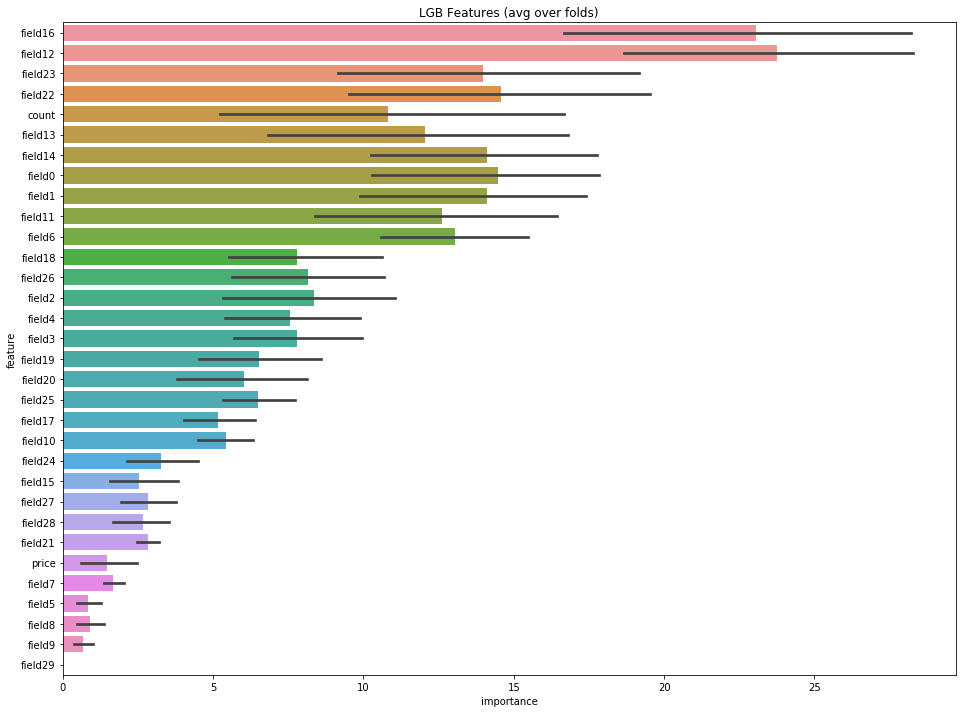

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=all_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1)

In [16]:
import pickle
pickle.dump(result_dict,open(f'results/results_dict_lightgbm2_01_12.pkl','wb'))
pd.DataFrame(result_dict['oof'], columns=['proba'], index=X.index).to_csv(f'results/oof_lightgbm2_01_12.csv')
pd.DataFrame(result_dict['prediction'], columns=['proba'], index=test.index).to_csv(f'results/prediction_lightgbm2_01_12.csv')

sample_submission = pd.read_csv('data/onetwotrip_challenge_sub1.csv')

In [17]:
sub1 = pd.DataFrame(result_dict['prediction'], columns=['proba'])
sample_submission['proba'] = sub1

In [18]:
sample_submission.to_csv(f'results/submission_lightgbm3_01_12.csv')

In [19]:
sample_submission

,orderid,proba
0,0,0.009170714075932
1,1,0.010315089490714
2,2,0.029699811030630
3,3,0.027947971539184
4,4,0.007515440955852
5,5,0.012138633223573
6,6,0.018927980650695
7,7,0.015645251700031
8,8,0.027340867086023
9,9,0.015568245727445


In [13]:
sample_submission

,orderid,proba
0,0,0.014643307247381
1,1,0.010895565409693
2,2,0.037689039106266
3,3,0.023171794189020
4,4,0.009482417805432
5,5,0.014920297086607
6,6,0.017436019953772
7,7,0.017732457475910
8,8,0.021822710167141
9,9,0.015042431387556


In [144]:
pd.DataFrame(result_dict['prediction'], columns=['proba'], index=df_test['orderid'])

,proba
orderid,
0,0.013593509914278
1,0.013566676890900
2,0.033268143911663
3,0.020821534048087
4,0.011447445038781
5,0.014526480491894
6,0.016774929967094
7,0.017217144876385
8,0.023055158400375
